##### Copyright 2020 The TensorFlow Quantum Authors.

# MaxCut QAOA

Authors : Michael Streif, David Von Dollen

Contributors : Michael Broughton

Created : 2019

Last updated : 2020-Mar-05

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorflow/quantum/blob/research/qaoa/qaoa.ipynb)

This notebook shows an example of how to optimize variational parameters for QAOA using TFQ

First we must install the required libraries

In [2]:
import tensorflow as tf
import cirq
import tensorflow_quantum as tfq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
#supress warning for matplotlib
import warnings
warnings.filterwarnings("ignore")

In [4]:
import networkx as nx
import cirq
from cirq.pasqal import PasqalNoiseModel

We can use QAOA to solve Max-cut. First we need to generate a 3-regular graph with 10 nodes upon which to find the Max-cut using QAOA

In [5]:
# generate a 3-regular graph with 8 nodes
maxcut_graph = nx.random_regular_graph(n=8,d=3)

Let's visualize the graph

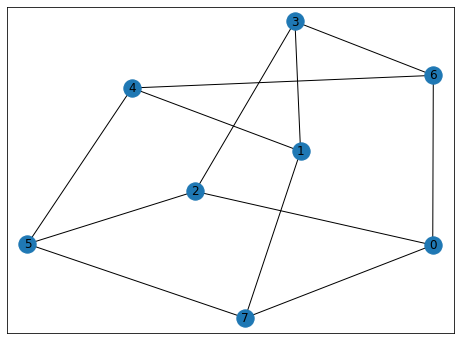

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6));
nx.draw_networkx(maxcut_graph, ax=ax)

In [7]:
from cirq.pasqal import PasqalVirtualDevice, PasqalDevice

p_qubits = cirq.GridQubit.square(3, 3)
p_device=PasqalVirtualDevice(control_radius=4, qubits=p_qubits)
p_named_device=PasqalDevice(qubits=cirq.NamedQubit.range(9, prefix='q'))

In [8]:
# create layer of hadamards to initialize the superposition state of all 
# computational states
hadamard_circuit = cirq.Circuit(device=p_device)

square_Y = cirq.YPowGate(exponent=0.5)
for node in maxcut_graph.nodes():
    qubit = p_qubits[node]
    hadamard_circuit.append(cirq.H.on(qubit))

(3, 0): ───H───

(3, 1): ───H───

(3, 2): ───H───

(4, 0): ───H───

(4, 1): ───H───

(4, 2): ───H───

(5, 0): ───H───

(5, 1): ───H───


In [9]:
# define the two parameters for one block of QAOA
qaoa_parameters = sympy.symbols('a b')

In [10]:
# define the the mixing and the cost Hamiltonian, H_M and H_P
mixing_ham = 0
for node in maxcut_graph.nodes():
    qubit = cirq_qubits[node]
    mixing_ham += cirq.PauliString(cirq.X(qubit))

cost_ham = maxcut_graph.number_of_edges()/2
for edge in maxcut_graph.edges():
    qubit1 = cirq_qubits[edge[0]]
    qubit2 = cirq_qubits[edge[1]]
    cost_ham += cirq.PauliString(1/2*(cirq.Z(qubit1)*cirq.Z(qubit2)))

# generate the qaoa circuit
qaoa_circuit = tfq.util.exponential(operators = [cost_ham, mixing_ham], 
                                    coefficients = qaoa_parameters)

Subsequently, we use these ingredients to build our model. We note here in this case that QAOA has no input data and labels, as we have mapped our graph to the QAOA circuit. To use the TFQ framework we specify the Hadamard circuit as input and convert it to a TFQ tensor. We may then construct a tf.keras model using our QAOA circuit and cost in a TFQ PQC layer, and use a single instance sample for training the variational parameters of the QAOA with the Hadamard gates as an input layer and a target value of $0$ for our loss function. This translates into the following code:

In [11]:
# define the model and training data
model_circuit, model_readout = qaoa_circuit, cost_ham
input_ = [hadamard_circuit]
input_ = tfq.convert_to_tensor(input_)
optimum = [0]

In [12]:
# Build the Keras model.
optimum=np.array(optimum)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string))
model.add(tfq.layers.PQC(model_circuit, model_readout))
tfq.layers.PQC

tensorflow_quantum.python.layers.high_level.pqc.PQC

To optimize the parameters of the ansatz state, we use a classical optimization routine. In general, it would be possible to use pre-calculated parameters  or to implement for QAOA tailored optimization routines. For this tutorial, we choose the Adam optimizer implemented in tensorflow. We also choose the mean absolute error as our loss function.

In [13]:
model.compile(loss=tf.keras.losses.mean_absolute_error,
              optimizer=tf.keras.optimizers.Adadelta())
    
history = model.fit(input_,optimum,epochs=300,verbose=1)

Train on 1 samples
Epoch 1/300
1/1 [==============================] - 2s 2s/sample - loss: 3.7798
Epoch 2/300
1/1 [==============================] - 0s 9ms/sample - loss: 3.7798
Epoch 3/300
1/1 [==============================] - 0s 12ms/sample - loss: 3.7798
Epoch 4/300
1/1 [==============================] - 0s 15ms/sample - loss: 3.7798
Epoch 5/300
1/1 [==============================] - 0s 15ms/sample - loss: 3.7798
Epoch 6/300
1/1 [==============================] - 0s 20ms/sample - loss: 3.7798
Epoch 7/300
1/1 [==============================] - 0s 14ms/sample - loss: 3.7798
Epoch 8/300
1/1 [==============================] - 0s 14ms/sample - loss: 3.7798
Epoch 9/300
1/1 [==============================] - 0s 19ms/sample - loss: 3.7798
Epoch 10/300
1/1 [==============================] - 0s 16ms/sample - loss: 3.7798
Epoch 11/300
1/1 [==============================] - 0s 23ms/sample - loss: 3.7798
Epoch 12/300
1/1 [==============================] - 0s 13ms/sample - loss: 3.7798
Epoch 13/

1/1 [==============================] - 0s 9ms/sample - loss: 3.7794
Epoch 102/300
1/1 [==============================] - 0s 11ms/sample - loss: 3.7794
Epoch 103/300
1/1 [==============================] - 0s 8ms/sample - loss: 3.7794
Epoch 104/300
1/1 [==============================] - 0s 8ms/sample - loss: 3.7794
Epoch 105/300
1/1 [==============================] - 0s 11ms/sample - loss: 3.7794
Epoch 106/300
1/1 [==============================] - 0s 9ms/sample - loss: 3.7794
Epoch 107/300
1/1 [==============================] - 0s 9ms/sample - loss: 3.7794
Epoch 108/300
1/1 [==============================] - 0s 8ms/sample - loss: 3.7794
Epoch 109/300
1/1 [==============================] - 0s 9ms/sample - loss: 3.7794
Epoch 110/300
1/1 [==============================] - 0s 10ms/sample - loss: 3.7794
Epoch 111/300
1/1 [==============================] - 0s 9ms/sample - loss: 3.7793
Epoch 112/300
1/1 [==============================] - 0s 10ms/sample - loss: 3.7793
Epoch 113/300
1/1 [=======

Epoch 201/300
1/1 [==============================] - 0s 11ms/sample - loss: 3.7789
Epoch 202/300
1/1 [==============================] - 0s 11ms/sample - loss: 3.7789
Epoch 203/300
1/1 [==============================] - 0s 11ms/sample - loss: 3.7789
Epoch 204/300
1/1 [==============================] - 0s 9ms/sample - loss: 3.7789
Epoch 205/300
1/1 [==============================] - 0s 9ms/sample - loss: 3.7789
Epoch 206/300
1/1 [==============================] - 0s 10ms/sample - loss: 3.7789
Epoch 207/300
1/1 [==============================] - 0s 11ms/sample - loss: 3.7789
Epoch 208/300
1/1 [==============================] - 0s 10ms/sample - loss: 3.7789
Epoch 209/300
1/1 [==============================] - 0s 10ms/sample - loss: 3.7789
Epoch 210/300
1/1 [==============================] - 0s 10ms/sample - loss: 3.7789
Epoch 211/300
1/1 [==============================] - 0s 8ms/sample - loss: 3.7789
Epoch 212/300
1/1 [==============================] - 0s 10ms/sample - loss: 3.7789
Epoch 2

1/1 [==============================] - 0s 11ms/sample - loss: 3.7784


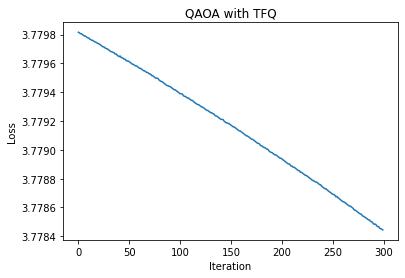

In [14]:
plt.plot(history.history['loss'])
plt.title("QAOA with TFQ")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()


In [15]:
# Read out the optimal paramters and sample from the final state 1000 times
#from cirq.pasqal import PasqalNoiseModel

params = model.trainable_variables
add = tfq.layers.AddCircuit()
output_circuit = add(input_, append =qaoa_circuit )

p_noise_model = PasqalNoiseModel(device=p_named_device)
my_sampler = cirq.DensityMatrixSimulator(noise=p_noise_model)

sample_layer1 = tfq.layers.Sample(backend=my_sampler)
output1 = sample_layer1(output_circuit,  symbol_names=qaoa_parameters, symbol_values = params, repetitions=1000)

sample_layer = tfq.layers.Sample()
output = sample_layer(output_circuit,  symbol_names=qaoa_parameters, symbol_values = params, repetitions=1000)

Instructions for updating:
reduction_indices is deprecated, use axis instead


In [16]:
# Translate output in cut sets
cuts_qaoa = []
for bit_string in output.values:
  temp = []
  for pos, bit in enumerate(bit_string):
    if bit==1:
      temp.append(pos)
  cuts_qaoa.append(temp)


cuts_qaoa1 = []
for bit_string in output1.values:
  temp1 = []
  for pos, bit in enumerate(bit_string):
    if bit==1:
      temp1.append(pos)
  cuts_qaoa1.append(temp1)
#print(cuts_qaoa)
#print(cuts_qaoa1)

In [17]:
# Generate a list with all possible subsets
from itertools import combinations
sub_lists = []
for i in range(0, len(maxcut_graph.nodes())+1):
  temp = [list(x) for x in combinations(maxcut_graph.nodes(), i)]
  sub_lists.extend(temp)

In [18]:
# Calculate the cut_size for all possible cuts
cut_size = []
for sub_list in sub_lists:
  cut_size.append(nx.algorithms.cuts.cut_size(maxcut_graph,sub_list))

# Calculate the cut_size for the cuts found with QAOA
cut_size_qaoa = []
for cut in cuts_qaoa:
  cut_size_qaoa.append(nx.algorithms.cuts.cut_size(maxcut_graph,cut))


cut_size_qaoa1 = []
for cut in cuts_qaoa1:
  cut_size_qaoa1.append(nx.algorithms.cuts.cut_size(maxcut_graph,cut))

In [19]:
# Calculate the approximation ratio
print(np.mean(cut_size_qaoa)/np.max(cut_size))
print(np.mean(cut_size_qaoa1)/np.max(cut_size))

0.8289
0.6829
